In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import numpy as np
import scipy as sp
import h5py
from scipy.interpolate import interp1d
from scipy.linalg import sqrtm, solve_sylvester, solve_lyapunov, expm
from scipy.io import loadmat
import matplotlib.pyplot as plt
import sys
import time
import pseudo
import os
import glob
import miscUtil
import ops
%matplotlib inline
#%matplotlib notebook

os.environ['DATA'] = os.environ['DATA186']
physDataDir = os.environ['DATA'] + 'phys/'
specDataDir = os.environ['DATA'] + 'spec/'
covDataDir = os.environ['DATA'] + 'cov/'
libDir = os.environ['LINLIB']
figureFolder = 'turbImpRes/'

# Turbulent impulse response


The impulse function (in $y$) is defined as
$$ f_s(y) = \frac{1}{2\sqrt{\pi\epsilon}} e^{ -\frac{(y-y_0)^2}{4\epsilon}}, \quad \epsilon > 0 $$
The values used for $y_0$ and $\epsilon$ are $y_0 = -0.9$ and $\epsilon = 1/2000$.

The state equation is
$$ \phi(y;k_x,k_z,t) = \mathcal{G}(y;k_x,k_z,t)  $$
where $\mathcal{G}$ is computed as an impulse response. 

The amplifications, $||G_s||_2 $, are defined as integrated HS norms over wavenumber and temporal spaces in Eq. 10.3, 10.4


# Streamwise constant perturbations

## Fig. 10.2   $||\mathcal{G}_s||_2(k_z)$ for streamwise constant perturbations

In [4]:
# Initialization
Re = 2000.      # This is ReTau 
# Grid
N = 251   # Wall-normal
aArr = np.array([0.])
nb = 256
bArr = np.linspace(15./nb, 15., nb)


# G_{s} has 3 components, so 
Gs2 = np.zeros((aArr.size, bArr.size, 4))

y, DM = pseudo.chebdif(N,2)

# Impulse function
y0 = -0.9; eps = 1./2000.
fs = 1./(2.*np.sqrt(np.pi * eps )) * np.exp(-(y-y0)**2 / 4./eps )

# Impulse input to the velocity vorticity state (i.e., B*fs)
# Since there are 3 fs (and a total), I'll use Fs of size 4x2N
Fs = np.zeros((4, 2*N), dtype=np.complex)
Fsadj = Fs.copy()

D4 = pseudo.cheb4c(N)
D1 = DM[:,:,0]; D2 = DM[:,:,1]

turbDict = ops.turbMeanChannel(N=N, Re=Re)
Umat   = np.diag(turbDict['U'])
dUmat  = np.diag(turbDict['dU'])
d2Umat  = np.diag(turbDict['d2U'])
I1 = np.identity(N); I2 = np.identity(2*N)
Z1 = np.zeros((N,N))
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si= weightDict['W3SqrtInv']
W2s = weightDict['W2Sqrt']
W2si= weightDict['W2SqrtInv']
W2  = weightDict['W2']

for i0 in range(aArr.size):
    a = aArr[i0]
    for i1 in range(bArr.size):
        b = bArr[i1]
        print("b=",b)
        #A,C,B = statInst.makeSystemNew()
        Delta = D2 - (a**2 + b**2) * I1
        DeltaSq = D4 + ((a**2 + b**2)**2) * I1 - 2.*(a**2+b**2)*D2
        DeltaInv = np.linalg.solve(Delta, I1)
        
        LOS = -1.j*a* Umat @ Delta + 1.j*a* d2Umat + DeltaSq/Re
        LSQ = -1.j*a*Umat + Delta/Re
        Lco = -1.j*b*dUmat
        k2 = a**2 + b**2
        A = np.vstack(( 
                np.hstack(( DeltaInv @ LOS, Z1 )),
                np.hstack(( Lco           , LSQ)) ))
        LOSadj = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + (DeltaInv @ DeltaSq)/Re
        Lcoadj = -1.j*b*DeltaInv @ dUmat
        LSQadj = 1.j*a*Umat + Delta/Re
        Aadj = np.vstack((
                np.hstack(( LOSadj, Lcoadj)),
                np.hstack(( Z1    , LSQadj))  ))
        B = np.vstack((
                DeltaInv@ np.hstack(( -1.j*a*D1, -k2*I1, -1.j*b*D1 )),
                np.hstack((1.j*b*I1, Z1, -1.j*a*I1))  ))
        C = (1./k2) * np.vstack((
                np.hstack((1.j*a*D1, -1.j*b*I1)),
                np.hstack((k2 * I1 , Z1       )),
                np.hstack((1.j*b*D1,  1.j*a*I1)) ))
        Badj = C; Cadj = B
        
        Fs[0,:N] = -1.j*a*DeltaInv @ (D1@fs);  Fs[0,N:] = 1.j*b*fs
        Fs[1,:N] = -(a**2+b**2)*DeltaInv @ fs; Fs[1,N:] = 0.
        Fs[2,:N] = -1.j*b*DeltaInv @ (D1@fs);  Fs[2,N:] = -1.j*a*fs
        Fs[3] = Fs[0]+Fs[1]+Fs[2]
        
        Fsadj[0] = 1./(a**2+b**2) * W2 @ np.concatenate(( -1.j*a*D1@fs, -1.j*b*fs  ))
        Fsadj[1] = W2 @ np.concatenate(( fs, np.zeros(N,dtype=np.complex) ))
        Fsadj[2] = 1./(a**2+b**2) * W2 @ np.concatenate(( -1.j*b*D1@fs,  1.j*a*fs  ))
        Fsadj[3] = Fsadj[0] + Fsadj[1] + Fsadj[2]
        
        Y = solve_sylvester( Aadj, A, -Cadj @ C )
        for i3 in range(4):
            Gs2[i0,i1,i3]  = np.real(np.trace( Fsadj[i3].reshape((1,2*N)) @ Y @ Fs[i3].reshape((2*N,1)) ))

        

Using parameters Re=2000, alfa=25.4, kapa=0.426, N=251
b= 0.05859375
b= 0.1171875
b= 0.17578125
b= 0.234375
b= 0.29296875
b= 0.3515625
b= 0.41015625
b= 0.46875
b= 0.52734375
b= 0.5859375
b= 0.64453125
b= 0.703125
b= 0.76171875
b= 0.8203125
b= 0.87890625
b= 0.9375
b= 0.99609375
b= 1.0546875
b= 1.11328125
b= 1.171875
b= 1.23046875
b= 1.2890625
b= 1.34765625
b= 1.40625
b= 1.46484375
b= 1.5234375
b= 1.58203125
b= 1.640625
b= 1.69921875
b= 1.7578125
b= 1.81640625
b= 1.875
b= 1.93359375
b= 1.9921875
b= 2.05078125
b= 2.109375
b= 2.16796875
b= 2.2265625
b= 2.28515625
b= 2.34375
b= 2.40234375
b= 2.4609375
b= 2.51953125
b= 2.578125
b= 2.63671875
b= 2.6953125
b= 2.75390625
b= 2.8125
b= 2.87109375
b= 2.9296875
b= 2.98828125
b= 3.046875
b= 3.10546875
b= 3.1640625
b= 3.22265625
b= 3.28125
b= 3.33984375
b= 3.3984375
b= 3.45703125
b= 3.515625
b= 3.57421875
b= 3.6328125
b= 3.69140625
b= 3.75
b= 3.80859375
b= 3.8671875
b= 3.92578125
b= 3.984375
b= 4.04296875
b= 4.1015625
b= 4.16015625
b= 4.21875
b= 4.27

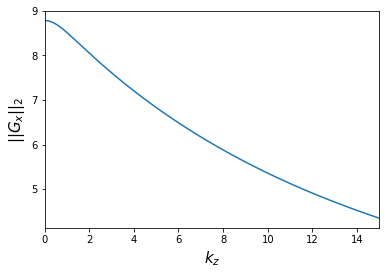

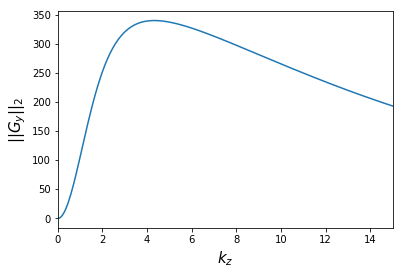

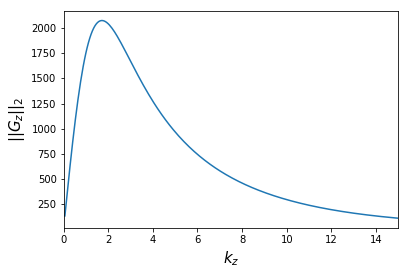

In [5]:
Gs = np.sqrt(2.*Gs2)
# I suppose the factor 2 is there to account for -beta
plt.plot(bArr, Gs[0,:,0])
plt.xlim([0., 15.])
plt.xlabel('$k_z$',fontsize=15); plt.ylabel('$||G_x||_2$',fontsize=15)
plt.savefig(figureFolder+'fig10p2a.eps',format='eps')
plt.show()

plt.plot(bArr, Gs[0,:,1])
plt.xlim([0., 15.])
plt.xlabel('$k_z$',fontsize=15); plt.ylabel('$||G_y||_2$',fontsize=15)
plt.savefig(figureFolder+'fig10p2b.eps',format='eps')
plt.show()

plt.plot(bArr, Gs[0,:,2])
plt.xlim([0., 15.])
plt.xlabel('$k_z$',fontsize=15); plt.ylabel('$||G_z||_2$',fontsize=15)
plt.savefig(figureFolder+'fig10p2c.eps',format='eps')
plt.show()



## Fig. 10.3 Impulse amplification integrated over wavenumber space
The integral of the HS norm over time can be obtained as the H2 norm, but the integral of the HS norm over wavenumber space, not so much. We need to compute the HS norms individually and then integrate them. 

In [7]:
# Initialization
Re = 2000.       
# Grid
N = 251   # Wall-normal
aArr = np.array([0.])
nb = 256
bArr = np.linspace(200./nb,200., nb)
tArr = np.concatenate(( np.arange(1.,5.1),np.arange(7.5,51.,2.5), np.arange(55., 101., 5.), np.arange(100., 201.,20.) ))

# We need HS norm at each b and t for three components, Gx, Gy, Gz; I'll not do the extra Gtotal
#HSnormArr = np.zeros((tArr.size, bArr.size, 3))
# Don't want to reset this to zeroes after the interrupt

y, DM = pseudo.chebdif(N,2)

# Impulse function
y0 = -0.9; eps = 1./2000.
fs = 1./(2.*np.sqrt(np.pi * eps )) * np.exp(-(y-y0)**2 / 4./eps )

# Impulse input to the velocity vorticity state (i.e., B*fs)
# Since there are 3 fs (and a total), I'll use Fs of size 4x2N
Fs = np.zeros((4, 2*N), dtype=np.complex)
Fsadj = Fs.copy()

D4 = pseudo.cheb4c(N)
D1 = DM[:,:,0]; D2 = DM[:,:,1]

turbDict = ops.turbMeanChannel(N=N, Re=Re)
Umat   = np.diag(turbDict['U'])
dUmat  = np.diag(turbDict['dU'])
d2Umat  = np.diag(turbDict['d2U'])
I1 = np.identity(N); I2 = np.identity(2*N)
Z1 = np.zeros((N,N))
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si= weightDict['W3SqrtInv']
W2s = weightDict['W2Sqrt']
W2si= weightDict['W2SqrtInv']
W2  = weightDict['W2']

def makeSystemTemp(a,b):
    # This time, we don't need the resolvent, but just the system matrices and their adjoints.
    Delta = D2 - (a**2 + b**2) * I1
    DeltaSq = D4 + ((a**2 + b**2)**2) * I1 - 2.*(a**2+b**2)*D2
    DeltaInv = np.linalg.solve(Delta, I1)

    LOS = -1.j*a* Umat @ Delta + 1.j*a* d2Umat + DeltaSq/Re
    LSQ = -1.j*a*Umat + Delta/Re
    Lco = -1.j*b*dUmat
    k2 = a**2 + b**2
    A = np.vstack(( 
            np.hstack(( DeltaInv @ LOS, Z1 )),
            np.hstack(( Lco           , LSQ)) ))
    LOSadj = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + (DeltaInv @ DeltaSq)/Re
    Lcoadj = -1.j*b*DeltaInv @ dUmat
    LSQadj = 1.j*a*Umat + Delta/Re
    Aadj = np.vstack((
            np.hstack(( LOSadj, Lcoadj)),
            np.hstack(( Z1    , LSQadj))  ))
    B = np.vstack((
            DeltaInv@ np.hstack(( -1.j*a*D1, -k2*I1, -1.j*b*D1 )),
            np.hstack((1.j*b*I1, Z1, -1.j*a*I1))  ))
    C = (1./k2) * np.vstack((
            np.hstack((1.j*a*D1, -1.j*b*I1)),
            np.hstack((k2 * I1 , Z1       )),
            np.hstack((1.j*b*D1,  1.j*a*I1)) ))
    Badj = C; Cadj = B

    Fs[0,:N] = -1.j*a*DeltaInv @ (D1@fs);  Fs[0,N:] = 1.j*b*fs
    Fs[1,:N] = -(a**2+b**2)*DeltaInv @ fs; Fs[1,N:] = 0.
    Fs[2,:N] = -1.j*b*DeltaInv @ (D1@fs);  Fs[2,N:] = -1.j*a*fs
    Fs[3] = Fs[0]+Fs[1]+Fs[2]

    Fsadj[0] = 1./(a**2+b**2) * W2 @ np.concatenate(( -1.j*a*D1@fs, -1.j*b*fs  ))
    Fsadj[1] = W2 @ np.concatenate(( fs, np.zeros(N,dtype=np.complex) ))
    Fsadj[2] = 1./(a**2+b**2) * W2 @ np.concatenate(( -1.j*b*D1@fs,  1.j*a*fs  ))
    Fsadj[3] = Fsadj[0] + Fsadj[1] + Fsadj[2]
    return A,Aadj, C, Cadj, Fs, Fsadj

a = 0.
#for i0 in range(tArr.size):
for i0 in range(10,tArr.size):
    # Restart at t = 20
    t = tArr[i0]
    print("t=",t)
    for i1 in range(bArr.size):
        b = bArr[i1]
        if i1%50 == 0: print("b=",b)
        A,Aadj, C,Cadj, Fs,Fsadj = makeSystemTemp(a,b)
        for i2 in range(3):
            Fst = Fs[i2].reshape((2*N,1)); Fsadjt = Fsadj[i2].reshape((1,2*N))
            HSnormArr[i0,i1,i2]= np.trace(
                C @ expm(t*A) @ Fst @ Fsadjt @ expm(t*Aadj) @ Cadj )
HSnormArrImpulseKz = HSnormArr.copy()            
        

Using parameters Re=2000, alfa=25.4, kapa=0.426, N=251
t= 20.0
b= 0.78125


/home/svadarevu/linenv/lib/python3.5/site-packages/ipykernel/__main__.py:93: ComplexWarning: Casting complex values to real discards the imaginary part


b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 22.5
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 25.0
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 27.5
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 30.0
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 32.5
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 35.0
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 37.5
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 40.0
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 42.5
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 45.0
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 47.5
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 50.0
b= 0.78125
b= 39.84375
b= 7

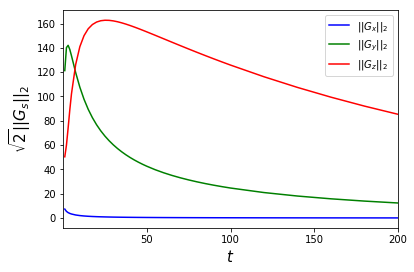

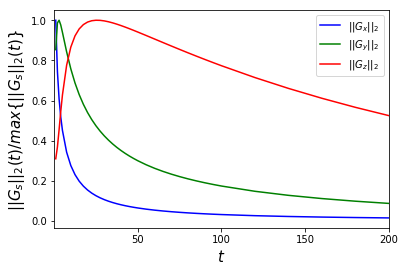

In [8]:
Gst2 = 4.*(1./2./np.pi) * np.trapz(HSnormArrImpulseKz,axis=1, dx = bArr[-1]-bArr[-2]) 
Gs = np.sqrt(Gst2)
# I suppose the factor 2 is there to account for -beta
plt.plot(tArr, Gs[:,0],'b-',label='$||G_x||_2$')
plt.plot(tArr, Gs[:,1],'g-',label='$||G_y||_2$')
plt.plot(tArr, Gs[:,2],'r-',label='$||G_z||_2$')
plt.xlim([0., 200.])
plt.xticks(np.arange(50., 201., 50.))
plt.xlabel('$t$',fontsize=15); plt.ylabel('$\sqrt{2}||G_s||_2$',fontsize=15)
plt.legend()
plt.savefig(figureFolder+'fig10p3a.eps',format='eps')
plt.show()

plt.plot(tArr, Gs[:,0]/np.max(Gs[:,0]),'b-',label='$||G_x||_2$')
plt.plot(tArr, Gs[:,1]/np.max(Gs[:,1]),'g-',label='$||G_y||_2$')
plt.plot(tArr, Gs[:,2]/np.max(Gs[:,2]),'r-',label='$||G_z||_2$')
plt.xlim([0., 200.])
plt.xticks(np.arange(50., 201., 50.))
plt.xlabel('$t$',fontsize=15); plt.ylabel('$||G_s||_2(t)/max\{||G_s||_2(t)\}$',fontsize=15)
plt.legend()
plt.savefig(figureFolder+'fig10p3b.eps',format='eps')
plt.show()



## Fig. 10.4  Velocity contours (in physical space including all wavenumbers) of impulse response

The impulse response at time $t$ for wavenumber pair $(k_x, k_z)$ is 
$$ \phi(y; k_x,k_z,t) = C(y;k_x,k_z) e^{A(y;k_x,k_z)t} F_s(y; k_x,k_z), $$ 
where $f_s$ was defined earlier. 

In [9]:
# Initialization
Re = 2000.       
# Grid
N = 251   # Wall-normal
aArr = np.array([0.])
nb = 512
bArr = np.linspace(15./nb, 15., nb)
tArr = np.array([5., 20., 100., 200.])

y, DM = pseudo.chebdif(N,2)

# Impulse function
y0 = -0.9; eps = 1./2000.
fs = 1./(2.*np.sqrt(np.pi * eps )) * np.exp(-(y-y0)**2 / 4./eps )

# Impulse input to the velocity vorticity state (i.e., B*fs)
# Since there are 3 fs (and a total), I'll use Fs of size 4x2N
Fs = np.zeros((4, 2*N), dtype=np.complex)
Fsadj = Fs.copy()

turbDict = ops.turbMeanChannel(N=N, Re=Re)
Umat   = np.diag(turbDict['U'])
dUmat  = np.diag(turbDict['dU'])
d2Umat  = np.diag(turbDict['d2U'])
D4 = pseudo.cheb4c(N)
D1 = DM[:,:,0]; D2 = DM[:,:,1]
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si= weightDict['W3SqrtInv']
W2s = weightDict['W2Sqrt']
W2si= weightDict['W2SqrtInv']
W2  = weightDict['W2']
I1 = np.identity(N); I2 = np.identity(2*N)
Z1 = np.zeros((N,N))

def makeSystemTemp(a,b):
    # This time, we don't need the resolvent, but just the system matrices and their adjoints.
    Delta = D2 - (a**2 + b**2) * I1
    DeltaSq = D4 + ((a**2 + b**2)**2) * I1 - 2.*(a**2+b**2)*D2
    DeltaInv = np.linalg.solve(Delta, I1)

    LOS = -1.j*a* Umat @ Delta + 1.j*a* d2Umat + DeltaSq/Re
    LSQ = -1.j*a*Umat + Delta/Re
    Lco = -1.j*b*dUmat
    k2 = a**2 + b**2
    A = np.vstack(( 
            np.hstack(( DeltaInv @ LOS, Z1 )),
            np.hstack(( Lco           , LSQ)) ))
    LOSadj = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + (DeltaInv @ DeltaSq)/Re
    Lcoadj = -1.j*b*DeltaInv @ dUmat
    LSQadj = 1.j*a*Umat + Delta/Re
    B = np.vstack((
            DeltaInv@ np.hstack(( -1.j*a*D1, -k2*I1, -1.j*b*D1 )),
            np.hstack((1.j*b*I1, Z1, -1.j*a*I1))  ))
    C = (1./k2) * np.vstack((
            np.hstack((1.j*a*D1, -1.j*b*I1)),
            np.hstack((k2 * I1 , Z1       )),
            np.hstack((1.j*b*D1,  1.j*a*I1)) ))
    Badj = C; Cadj = B

    Fs[0,:N] = -1.j*a*DeltaInv @ (D1@fs);  Fs[0,N:] = 1.j*b*fs
    Fs[1,:N] = -(a**2+b**2)*DeltaInv @ fs; Fs[1,N:] = 0.
    Fs[2,:N] = -1.j*b*DeltaInv @ (D1@fs);  Fs[2,N:] = -1.j*a*fs
    Fs[3] = Fs[0]+Fs[1]+Fs[2]

    return A,C, Fs

# Grid in physical space
zArr = np.linspace(-np.pi/2, np.pi/2, 80)
Z = np.tile(zArr.reshape((1,zArr.size)), [N,1])
Y = np.tile(y.reshape((N,1)),[1,zArr.size])

# We'll record the velocity components at each time instance here.
velField = np.zeros(( tArr.size, 3, N, zArr.size ))
strFunField = np.zeros(( tArr.size, N, zArr.size ))  #and the stream function


a = 0.
for i0 in range(tArr.size):
    t = tArr[i0]
    print("t=",t)
    for i1 in range(bArr.size):
        b = bArr[i1]
        if i1%50 == 0: print("b=",b)
        A, C, Fs = makeSystemTemp(a,b)
        
        # Response to impulse in spanwise
        velSpec = C @ expm(t*A) @ Fs[2].reshape((2*N,1))
        strFunSpec = - velSpec[N:2*N]/(1.j*b)
        velRe = velSpec.real; velIm = velSpec.imag
        # Adding up the field due to each Fourier mode
        # I could instead store the spectral fields and then do an inverse FFT, but whatever
        velField[i0,0] += 2.*velRe[   :N].reshape((N,1)) * np.cos(b*Z) - 2.*velIm[   :N].reshape((N,1)) * np.sin(b*Z)
        velField[i0,1] += 2.*velRe[N:2*N].reshape((N,1)) * np.cos(b*Z) - 2.*velIm[N:2*N].reshape((N,1)) * np.sin(b*Z)
        velField[i0,2] += 2.*velRe[2*N :].reshape((N,1)) * np.cos(b*Z) - 2.*velIm[2*N: ].reshape((N,1)) * np.sin(b*Z)
        strFunField[i0] += 2.*strFunSpec.real.reshape((N,1)) * np.cos(b*Z) - 2.*strFunSpec.imag.reshape((N,1)) * np.sin(b*Z)
velField = velField * (bArr[-1]-bArr[-2]) / (2.*np.pi)
strFunField = strFunField * (bArr[-1]-bArr[-2]) / (2.*np.pi)

Using parameters Re=2000, alfa=25.4, kapa=0.426, N=251
t= 5.0
b= 0.029296875
b= 1.494140625
b= 2.958984375
b= 4.423828125
b= 5.888671875
b= 7.353515625
b= 8.818359375
b= 10.283203125
b= 11.748046875
b= 13.212890625
b= 14.677734375
t= 20.0
b= 0.029296875
b= 1.494140625
b= 2.958984375
b= 4.423828125
b= 5.888671875
b= 7.353515625
b= 8.818359375
b= 10.283203125
b= 11.748046875
b= 13.212890625
b= 14.677734375
t= 100.0
b= 0.029296875
b= 1.494140625
b= 2.958984375
b= 4.423828125
b= 5.888671875
b= 7.353515625
b= 8.818359375
b= 10.283203125
b= 11.748046875
b= 13.212890625
b= 14.677734375
t= 200.0
b= 0.029296875
b= 1.494140625
b= 2.958984375
b= 4.423828125
b= 5.888671875
b= 7.353515625
b= 8.818359375
b= 10.283203125
b= 11.748046875
b= 13.212890625
b= 14.677734375


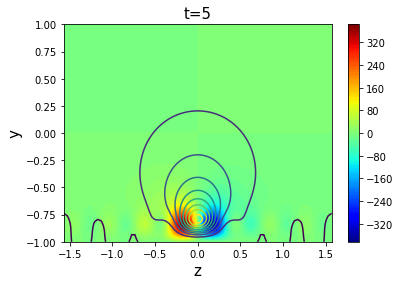

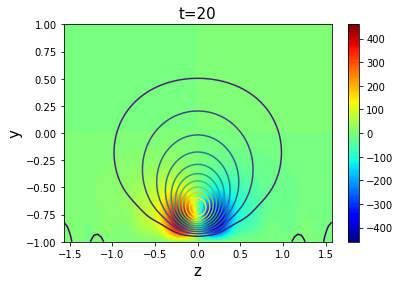

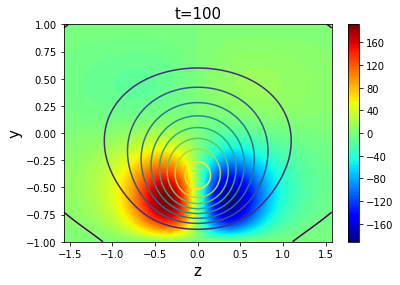

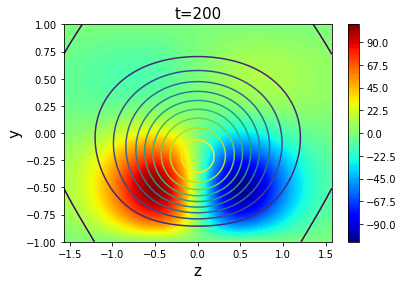

In [17]:
plt.contourf(Z,Y,velField[0,0],100, cmap="jet")
#plt.clim([-47.,47.])
#plt.colorbar(ticks=np.arange(-40.,41.,10.))
plt.colorbar()
plt.contour( Z,Y,strFunField[0],10)
plt.xlabel("z", fontsize=15); plt.ylabel("y", fontsize=15)
plt.title("t=5",fontsize=15)
plt.savefig(figureFolder+'fig10p4a.eps',format='eps')
plt.show()

plt.contourf(Z,Y,velField[1,0],100, cmap="jet")
#plt.clim([-50.,50.])
#plt.colorbar(ticks=np.arange(-50.,51.,10.))
plt.colorbar()
plt.contour( Z,Y,strFunField[1],10)
plt.xlabel("z", fontsize=15); plt.ylabel("y", fontsize=15)
plt.title("t=20",fontsize=15)
plt.savefig(figureFolder+'fig10p4b.eps',format='eps')
plt.show()

plt.contourf(Z,Y,velField[2,0],100, cmap="jet")
#plt.clim([-27.,27.])
#plt.colorbar(ticks=np.arange(-25.,26.,5.))
plt.colorbar()
plt.contour( Z,Y,strFunField[2],10)
plt.xlabel("z", fontsize=15); plt.ylabel("y", fontsize=15)
plt.title("t=100",fontsize=15)
plt.savefig(figureFolder+'fig10p4c.eps',format='eps')
plt.show()

plt.contourf(Z,Y,velField[3,0],100, cmap="jet")
#plt.clim([-15.,15.])
#plt.colorbar(ticks=np.arange(-15.,16.,5.))
plt.colorbar()
plt.contour( Z,Y,strFunField[3],10)
plt.xlabel("z", fontsize=15); plt.ylabel("y", fontsize=15)
plt.title("t=200",fontsize=15)
plt.savefig(figureFolder+'fig10p4d.eps',format='eps')
plt.show()

# 3d Perturbations

## Fig. 10.5  Impulse amplification for 3d perturbations

In [11]:
# Initialization
Re = 2000.       
# Grid
N = 251   # Wall-normal
aArr = 10.** np.linspace(-4., np.log10(3.02), 50)
bArr = 10.** np.linspace(-2., np.log10(15.84),90)

y, DM = pseudo.chebdif(N,2)

# Impulse function
y0 = -0.9; eps = 1./2000.
fs = 1./(2.*np.sqrt(np.pi * eps )) * np.exp(-(y-y0)**2 / 4./eps )

# Impulse input to the velocity vorticity state (i.e., B*fs)
# Since there are 3 fs (and a total), I'll use Fs of size 4x2N
Fs = np.zeros((4, 2*N), dtype=np.complex)
Fsadj = Fs.copy()

# H2 norm for each kx and kz, for impulse along x, y,z:
Gs2 = np.zeros((aArr.size, bArr.size, 3))

D4 = pseudo.cheb4c(N)
D1 = DM[:,:,0]; D2 = DM[:,:,1]

turbDict = ops.turbMeanChannel(N=N, Re=Re)
Umat   = np.diag(turbDict['U'])
dUmat  = np.diag(turbDict['dU'])
d2Umat  = np.diag(turbDict['d2U'])
I1 = np.identity(N); I2 = np.identity(2*N)
Z1 = np.zeros((N,N))
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si= weightDict['W3SqrtInv']
W2s = weightDict['W2Sqrt']
W2si= weightDict['W2SqrtInv']
W2  = weightDict['W2']


def makeSystemTemp(a,b):
    # This time, we don't need the resolvent, but just the system matrices and their adjoints.
    Delta = D2 - (a**2 + b**2) * I1
    DeltaSq = D4 + ((a**2 + b**2)**2) * I1 - 2.*(a**2+b**2)*D2
    DeltaInv = np.linalg.solve(Delta, I1)

    LOS = -1.j*a* Umat @ Delta + 1.j*a* d2Umat + DeltaSq/Re
    LSQ = -1.j*a*Umat + Delta/Re
    Lco = -1.j*b*dUmat
    k2 = a**2 + b**2
    A = np.vstack(( 
            np.hstack(( DeltaInv @ LOS, Z1 )),
            np.hstack(( Lco           , LSQ)) ))
    LOSadj = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + (DeltaInv @ DeltaSq)/Re
    Lcoadj = -1.j*b*DeltaInv @ dUmat
    LSQadj = 1.j*a*Umat + Delta/Re
    Aadj = np.vstack((
            np.hstack(( LOSadj, Lcoadj)),
            np.hstack(( Z1    , LSQadj))  ))
    B = np.vstack((
            DeltaInv@ np.hstack(( -1.j*a*D1, -k2*I1, -1.j*b*D1 )),
            np.hstack((1.j*b*I1, Z1, -1.j*a*I1))  ))
    C = (1./k2) * np.vstack((
            np.hstack((1.j*a*D1, -1.j*b*I1)),
            np.hstack((k2 * I1 , Z1       )),
            np.hstack((1.j*b*D1,  1.j*a*I1)) ))
    Badj = C; Cadj = B

    Fs[0,:N] = -1.j*a*DeltaInv @ (D1@fs);  Fs[0,N:] = 1.j*b*fs
    Fs[1,:N] = -(a**2+b**2)*DeltaInv @ fs; Fs[1,N:] = 0.
    Fs[2,:N] = -1.j*b*DeltaInv @ (D1@fs);  Fs[2,N:] = -1.j*a*fs
    Fs[3] = Fs[0]+Fs[1]+Fs[2]

    Fsadj[0] = 1./(a**2+b**2) * W2 @ np.concatenate(( -1.j*a*D1@fs, -1.j*b*fs  ))
    Fsadj[1] = W2 @ np.concatenate(( fs, np.zeros(N,dtype=np.complex) ))
    Fsadj[2] = 1./(a**2+b**2) * W2 @ np.concatenate(( -1.j*b*D1@fs,  1.j*a*fs  ))
    Fsadj[3] = Fsadj[0] + Fsadj[1] + Fsadj[2]
    return A,Aadj, C, Cadj, Fs, Fsadj

for i0 in range(aArr.size):
    a = aArr[i0]
    print("a=",a)
    for i1 in range(bArr.size):
        b = bArr[i1]
        A,Aadj, C,Cadj, Fs,Fsadj = makeSystemTemp(a,b)
        Y = solve_sylvester( Aadj, A, -Cadj @ C )
        for i3 in range(3):
            Gs2[i0,i1,i3]  = np.real(np.trace( Fsadj[i3].reshape((1,2*N)) @ Y @ Fs[i3].reshape((2*N,1)) ))

GsKxKz2 = Gs2.copy()            


Using parameters Re=2000, alfa=25.4, kapa=0.426, N=251
a= 0.0001
a= 0.000123432269175
a= 0.000152355250737
a= 0.000188055543192
a= 0.000232121224271
a= 0.000286512494354
a= 0.000353648873251
a= 0.000436516829165
a= 0.00053880262757
a= 0.000665056309583
a= 0.00082089409421
a= 0.00101324820801
a= 0.00125067525552
a= 0.0015437368479
a= 0.00190546942145
a= 0.00235196414533
a= 0.00290308271476
a= 0.00358334087085
a= 0.00442299894917
a= 0.00545940796854
a= 0.00673867113909
a= 0.00831769469922
a= 0.0102667193103
a= 0.0126724446145
a= 0.0156418859476
a= 0.0193071347669
a= 0.0238312345555
a= 0.0294154335842
a= 0.0363081371607
a= 0.0448159575926
a= 0.055317353409
a= 0.0682794645603
a= 0.0842788924873
a= 0.104027349433
a= 0.128403317967
a= 0.158491129063
a= 0.195629197043
a= 0.241469557079
a= 0.29805135367
a= 0.367891549141
a= 0.454096887208
a= 0.560502092134
a= 0.691840451094
a= 0.853954367856
a= 1.05405525396
a= 1.30104431832
a= 1.60590852508
a= 1.98220933338
a= 2.44668595999
a= 3.02


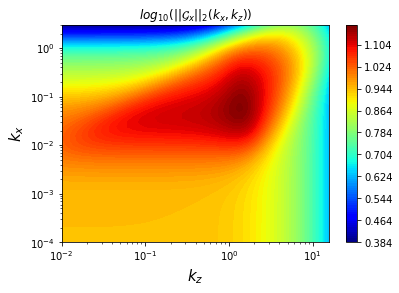

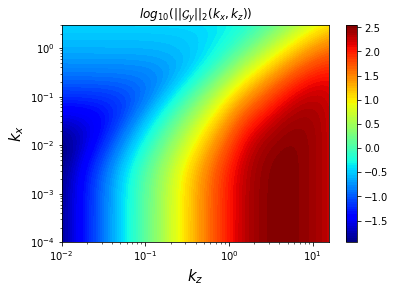

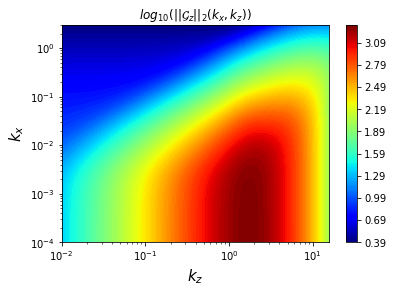

In [15]:
amplArr = np.sqrt(2.*GsKxKz2)
plt.contourf(bArr, aArr, np.log10(amplArr[:,:,0]),100,cmap="jet")
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
#plt.clim([0.6,1.5])
#plt.colorbar(ticks=np.arange(0.7,1.41,0.1))
plt.colorbar()
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{G}_{x}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig10p5a.eps',format='eps')
plt.show()

plt.contourf(bArr, aArr, np.log10(amplArr[:,:,1]),100,cmap="jet")
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
#plt.clim([-2.25,1.65])
#plt.colorbar(ticks=np.arange(-2.,1.55,0.5))
plt.colorbar()
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{G}_{y}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig10p5b.eps',format='eps')
plt.show()

plt.contourf(bArr, aArr, np.log10(amplArr[:,:,2]),100,cmap="jet")
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
#plt.clim([0.7,2.5])
#plt.colorbar(ticks=np.arange(0.8,2.55,0.2))
plt.colorbar()
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{G}_{z}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig10p5c.eps',format='eps')
plt.show()



## Response for impulse based at different locations

In [22]:
# Initialization
Re = 2000.       
# Grid
N = 251   # Wall-normal
aArr = 10.** np.linspace(-4., np.log10(3.02), 50)
bArr = 10.** np.linspace(-2., np.log10(15.84),90)

y, DM = pseudo.chebdif(N,2)

# Impulse function
y0 = -0.9; eps = 1./2000.


def amplArr_impulseFun(y0,eps):
    fs = 1./(2.*np.sqrt(np.pi * eps )) * np.exp(-(y-y0)**2 / 4./eps )

    # Impulse input to the velocity vorticity state (i.e., B*fs)
    # Since there are 3 fs (and a total), I'll use Fs of size 4x2N
    Fs = np.zeros((4, 2*N), dtype=np.complex)
    Fsadj = Fs.copy()

    # H2 norm for each kx and kz, for impulse along x, y,z:
    Gs2 = np.zeros((aArr.size, bArr.size, 3))

    D4 = pseudo.cheb4c(N)
    D1 = DM[:,:,0]; D2 = DM[:,:,1]

    turbDict = ops.turbMeanChannel(N=N, Re=Re)
    Umat   = np.diag(turbDict['U'])
    dUmat  = np.diag(turbDict['dU'])
    d2Umat  = np.diag(turbDict['d2U'])
    I1 = np.identity(N); I2 = np.identity(2*N)
    Z1 = np.zeros((N,N))
    weightDict = pseudo.weightMats(N)
    W3s = weightDict['W3Sqrt']
    W3si= weightDict['W3SqrtInv']
    W2s = weightDict['W2Sqrt']
    W2si= weightDict['W2SqrtInv']
    W2  = weightDict['W2']


    def makeSystemTemp(a,b):
        # This time, we don't need the resolvent, but just the system matrices and their adjoints.
        Delta = D2 - (a**2 + b**2) * I1
        DeltaSq = D4 + ((a**2 + b**2)**2) * I1 - 2.*(a**2+b**2)*D2
        DeltaInv = np.linalg.solve(Delta, I1)

        LOS = -1.j*a* Umat @ Delta + 1.j*a* d2Umat + DeltaSq/Re
        LSQ = -1.j*a*Umat + Delta/Re
        Lco = -1.j*b*dUmat
        k2 = a**2 + b**2
        A = np.vstack(( 
                np.hstack(( DeltaInv @ LOS, Z1 )),
                np.hstack(( Lco           , LSQ)) ))
        LOSadj = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + (DeltaInv @ DeltaSq)/Re
        Lcoadj = -1.j*b*DeltaInv @ dUmat
        LSQadj = 1.j*a*Umat + Delta/Re
        Aadj = np.vstack((
                np.hstack(( LOSadj, Lcoadj)),
                np.hstack(( Z1    , LSQadj))  ))
        B = np.vstack((
                DeltaInv@ np.hstack(( -1.j*a*D1, -k2*I1, -1.j*b*D1 )),
                np.hstack((1.j*b*I1, Z1, -1.j*a*I1))  ))
        C = (1./k2) * np.vstack((
                np.hstack((1.j*a*D1, -1.j*b*I1)),
                np.hstack((k2 * I1 , Z1       )),
                np.hstack((1.j*b*D1,  1.j*a*I1)) ))
        Badj = C; Cadj = B

        Fs[0,:N] = -1.j*a*DeltaInv @ (D1@fs);  Fs[0,N:] = 1.j*b*fs
        Fs[1,:N] = -(a**2+b**2)*DeltaInv @ fs; Fs[1,N:] = 0.
        Fs[2,:N] = -1.j*b*DeltaInv @ (D1@fs);  Fs[2,N:] = -1.j*a*fs
        Fs[3] = Fs[0]+Fs[1]+Fs[2]

        Fsadj[0] = 1./(a**2+b**2) * W2 @ np.concatenate(( -1.j*a*D1@fs, -1.j*b*fs  ))
        Fsadj[1] = W2 @ np.concatenate(( fs, np.zeros(N,dtype=np.complex) ))
        Fsadj[2] = 1./(a**2+b**2) * W2 @ np.concatenate(( -1.j*b*D1@fs,  1.j*a*fs  ))
        Fsadj[3] = Fsadj[0] + Fsadj[1] + Fsadj[2]
        return A,Aadj, C, Cadj, Fs, Fsadj

    for i0 in range(aArr.size):
        a = aArr[i0]
        print("a=",a)
        for i1 in range(bArr.size):
            b = bArr[i1]
            A,Aadj, C,Cadj, Fs,Fsadj = makeSystemTemp(a,b)
            Y = solve_sylvester( Aadj, A, -Cadj @ C )
            for i3 in range(3):
                Gs2[i0,i1,i3]  = np.real(np.trace( Fsadj[i3].reshape((1,2*N)) @ Y @ Fs[i3].reshape((2*N,1)) ))
    return Gs2

eps = 1./5000. # Sharper impulse than laminar. N is greater, so it's okay
y0Arr = -1.+ (1./Re)* 10.**np.linspace(1.5, 3., 11)
Gs2_y0 = np.zeros((y0Arr.size, aArr.size, bArr.size, 3))

startTime = time.time()
for ind in range(y0Arr.size):
    y0 = y0Arr[ind]
    print("y0=",y0)
    Gs2_y0[ind] = amplArr_impulseFun(y0,eps)
    print("Time elapsed(min):%d"%((time.time()-startTime)/60.) )



y0= -0.984188611699
Using parameters Re=2000, alfa=25.4, kapa=0.426, N=251
a= 0.0001
a= 0.000123432269175
a= 0.000152355250737
a= 0.000188055543192
a= 0.000232121224271
a= 0.000286512494354
a= 0.000353648873251
a= 0.000436516829165
a= 0.00053880262757
a= 0.000665056309583
a= 0.00082089409421
a= 0.00101324820801
a= 0.00125067525552
a= 0.0015437368479
a= 0.00190546942145
a= 0.00235196414533
a= 0.00290308271476
a= 0.00358334087085
a= 0.00442299894917
a= 0.00545940796854
a= 0.00673867113909
a= 0.00831769469922
a= 0.0102667193103
a= 0.0126724446145
a= 0.0156418859476
a= 0.0193071347669
a= 0.0238312345555
a= 0.0294154335842
a= 0.0363081371607
a= 0.0448159575926
a= 0.055317353409
a= 0.0682794645603
a= 0.0842788924873
a= 0.104027349433
a= 0.128403317967
a= 0.158491129063
a= 0.195629197043
a= 0.241469557079
a= 0.29805135367
a= 0.367891549141
a= 0.454096887208
a= 0.560502092134
a= 0.691840451094
a= 0.853954367856
a= 1.05405525396
a= 1.30104431832
a= 1.60590852508
a= 1.98220933338
a= 2.4466859599

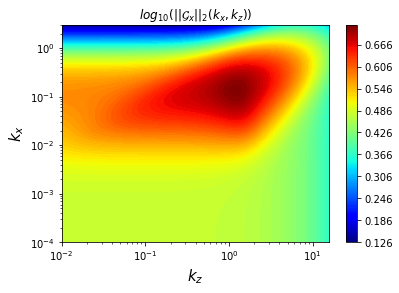

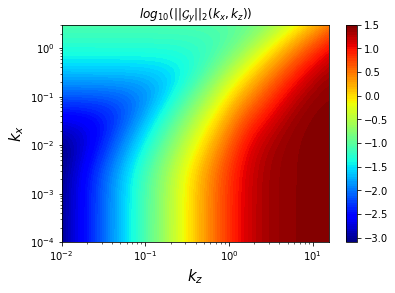

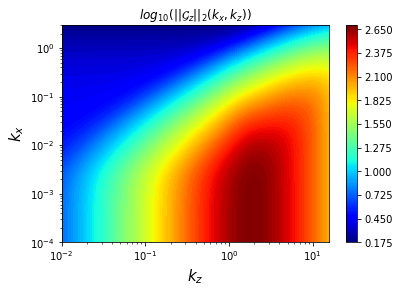

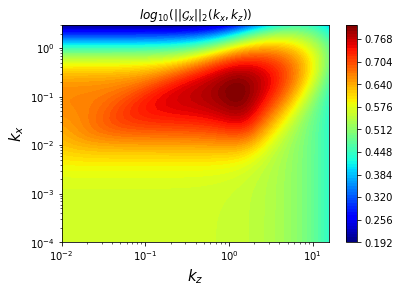

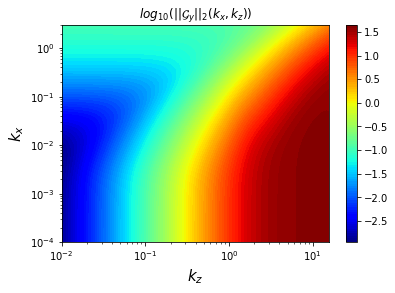

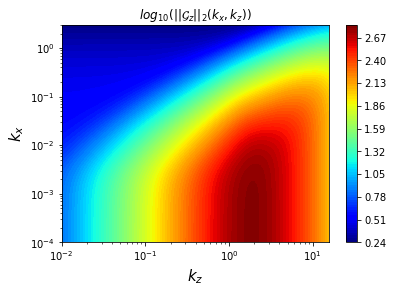

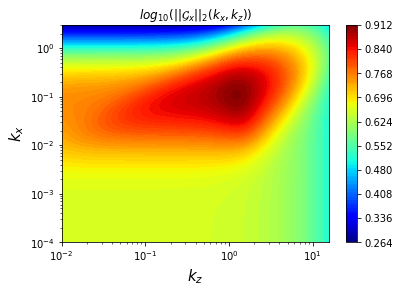

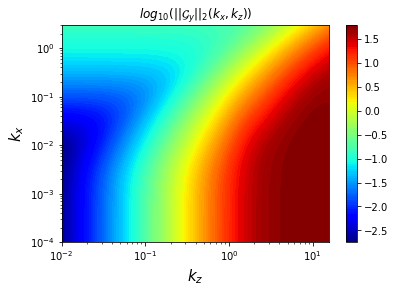

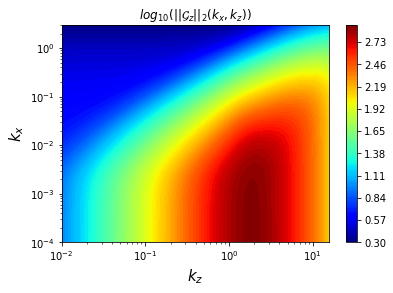

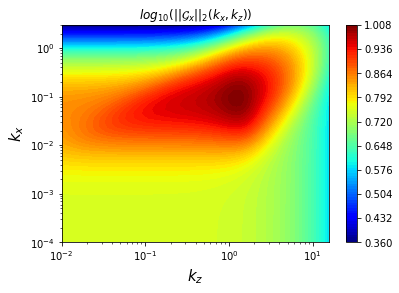

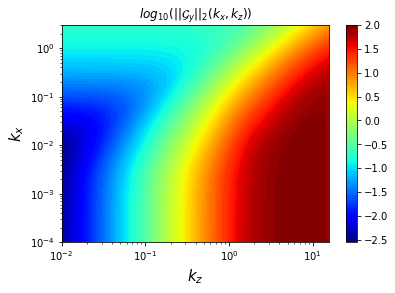

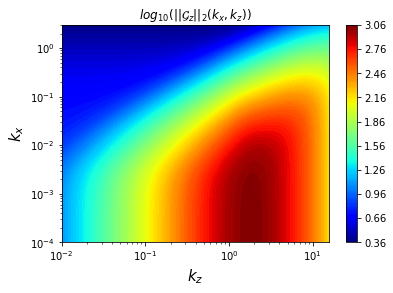

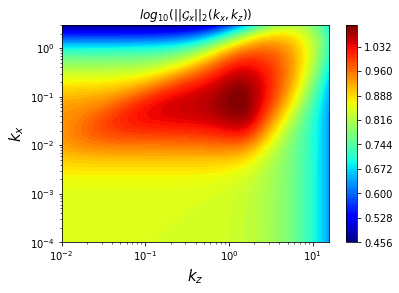

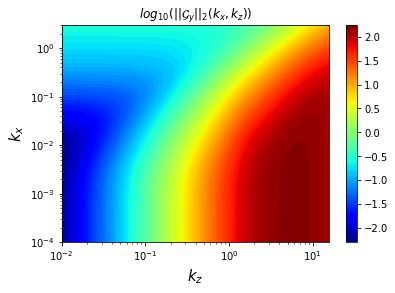

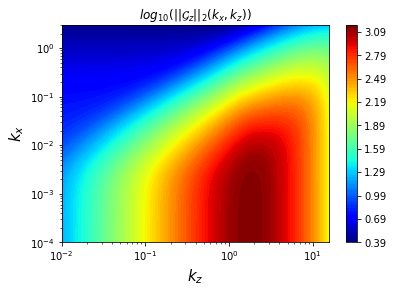

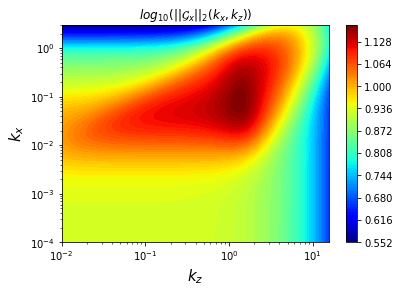

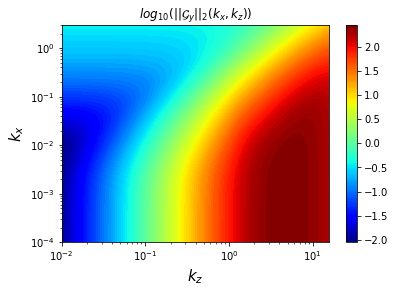

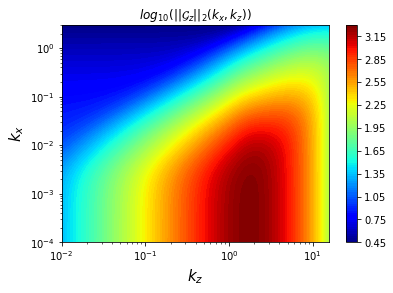

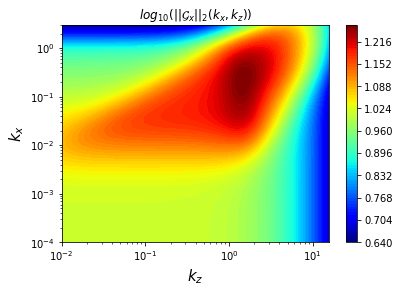

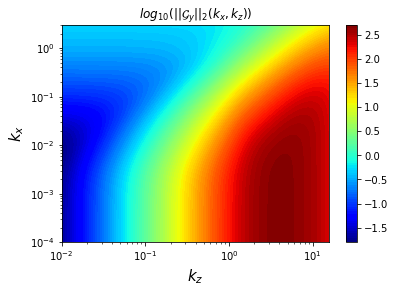

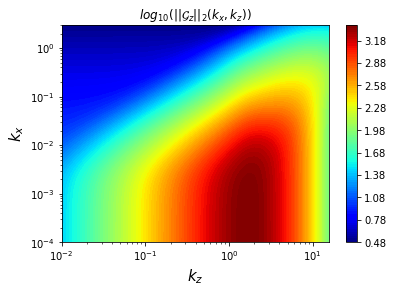

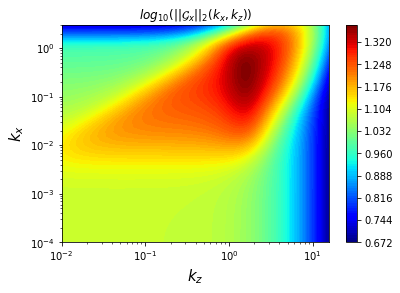

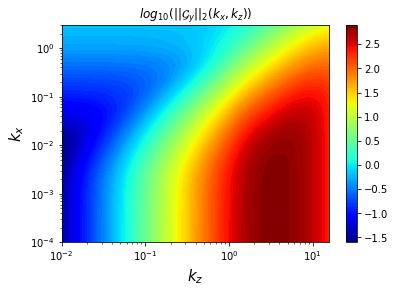

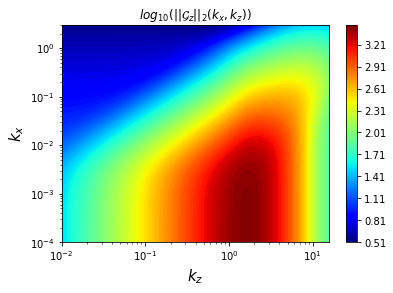

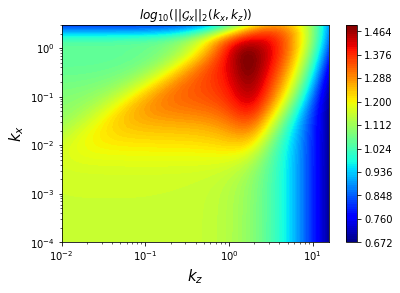

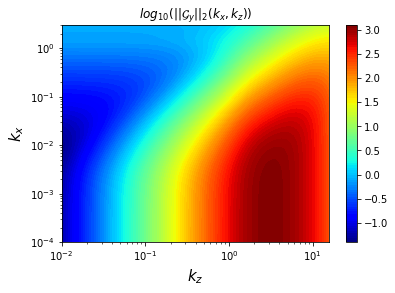

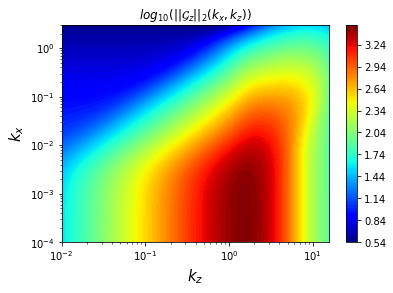

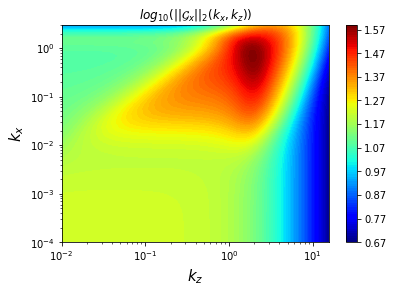

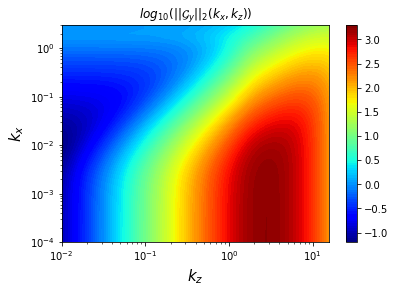

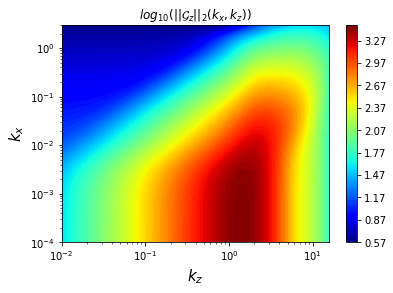

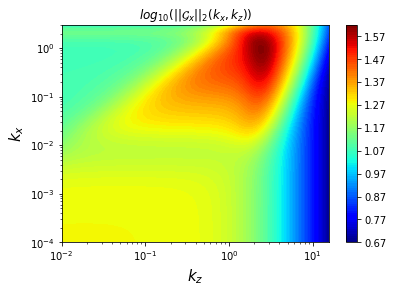

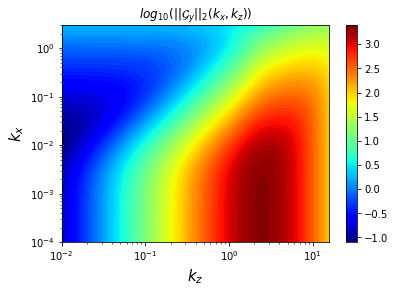

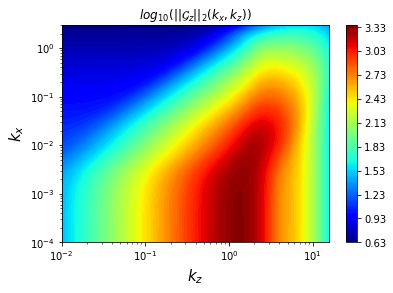

In [24]:
def plotContours(GsKxKz2,y0):
    amplArr = np.sqrt(2.*GsKxKz2)
    plt.contourf(bArr, aArr, np.log10(amplArr[:,:,0]),100,cmap=plt.get_cmap('jet'))
    plt.xscale("log"); plt.yscale("log")
    plt.xlim([0.01,15.84])
    plt.ylim([1.e-4, 3.02])
    #plt.clim([0.6,1.5])
    #plt.colorbar(ticks=np.arange(0.7,1.41,0.1))
    plt.colorbar()
    plt.xlabel("$k_z$",fontsize=15)
    plt.ylabel("$k_x$",fontsize=15)
    plt.title("$log_{10}(||\mathcal{G}_{x}||_2 (k_x,k_z))$")
    plt.savefig(figureFolder+'fig10p5a_y0mp%d.eps'%(-1000*y0),format='eps')
    plt.show()

    plt.contourf(bArr, aArr, np.log10(amplArr[:,:,1]),100,cmap=plt.get_cmap('jet'))
    plt.xscale("log"); plt.yscale("log")
    plt.xlim([0.01,15.84])
    plt.ylim([1.e-4, 3.02])
    #plt.clim([-2.25,1.65])
    #plt.colorbar(ticks=np.arange(-2.,1.55,0.5))
    plt.colorbar()
    plt.xlabel("$k_z$",fontsize=15)
    plt.ylabel("$k_x$",fontsize=15)
    plt.title("$log_{10}(||\mathcal{G}_{y}||_2 (k_x,k_z))$")
    plt.savefig(figureFolder+'fig10p5b_y0mp%d.eps'%(-1000*y0),format='eps')
    plt.show()

    plt.contourf(bArr, aArr, np.log10(amplArr[:,:,2]),100,cmap=plt.get_cmap('jet'))
    plt.xscale("log"); plt.yscale("log")
    plt.xlim([0.01,15.84])
    plt.ylim([1.e-4, 3.02])
    #plt.clim([0.7,2.5])
    #plt.colorbar(ticks=np.arange(0.8,2.55,0.2))
    plt.colorbar()
    plt.xlabel("$k_z$",fontsize=15)
    plt.ylabel("$k_x$",fontsize=15)
    plt.title("$log_{10}(||\mathcal{G}_{z}||_2 (k_x,k_z))$")
    plt.savefig(figureFolder+'fig10p5c_y0mp%d.eps'%(-1000*y0),format='eps')
    plt.show()
    
    return

for ind in range(y0Arr.size):
    plotContours(Gs2_y0[ind], y0Arr[ind])

## Impulse response

In [27]:
# Initialization
Re = 2000.       # This is ReTau, not Re_CL
# Grid
N = 251   # Wall-normal

# I'm using the same resolution as laminar. Will do a grid independence check later. 
aArr1 = np.concatenate(( np.linspace(0., 30., 193), np.linspace(-30., 0., 193)[1:-1]  ))
bArr1 = np.linspace(0., 45., 193)
tArr1 = np.array([0.1, 0.25, 1.0])

aArr2 = np.concatenate(( np.linspace(0., 8., 193), np.linspace(-8., 0., 193)[1:-1]  ))
bArr2 = np.linspace(0., 24., 193)
tArr2 = np.array([5., 15., 40.])

y, DM = pseudo.chebdif(N,2)

# Impulse function
y0 = -0.9; eps = 1./2000.
fs = 1./(2.*np.sqrt(np.pi * eps )) * np.exp(-(y-y0)**2 / 4./eps )

# Impulse input to the velocity vorticity state (i.e., B*fs)
# Since there are 3 fs (and a total), I'll use Fs of size 4x2N
Fs = np.zeros((4, 2*N), dtype=np.complex)
Fsadj = Fs.copy()


D4 = pseudo.cheb4c(N)
D1 = DM[:,:,0]; D2 = DM[:,:,1]


turbDict = ops.turbMeanChannel(N=N, Re=Re)
Umat   = np.diag(turbDict['U'])
dUmat  = np.diag(turbDict['dU'])
d2Umat  = np.diag(turbDict['d2U'])
I1 = np.identity(N); I2 = np.identity(2*N)
ZZ = np.zeros((N,N))
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si= weightDict['W3SqrtInv']
W2s = weightDict['W2Sqrt']
W2si= weightDict['W2SqrtInv']
W2  = weightDict['W2']

if True:
    # Grids in physical space
    # Early times:
    zArr1 = np.linspace(-6., 6., 256)
    xArr1 = np.linspace(-10., 10., 384)
    Z1 = np.tile(zArr1.reshape((zArr1.size,1)), [1,xArr1.size])
    X1 = np.tile(xArr1.reshape((1,xArr1.size)), [zArr1.size,1])

    # Later times
    zArr2 = np.linspace(-10., 10., 256)
    xArr2 = np.linspace(-15., 170., 384)
    Z2 = np.tile(zArr2.reshape((zArr2.size,1)), [1,xArr2.size])
    X2 = np.tile(xArr2.reshape((1,xArr2.size)), [zArr2.size,1])
    
    # I'll also record the full spectral flow field, just in case.
    uSpecArrFz1 = np.zeros(( tArr1.size, aArr1.size, bArr1.size, N), dtype=np.complex)

    # We'll record the velocity components at each time instance here.
    uFieldFz1 = np.zeros(( tArr1.size, zArr1.size, xArr1.size ))
    uFieldFz2 = np.zeros(( tArr2.size, zArr2.size, xArr2.size ))
    uFieldFy  = np.zeros(( tArr2.size, zArr2.size, xArr2.size ))
    uFieldFx  = np.zeros(( tArr2.size, zArr2.size, xArr2.size ))

    



def makeSystemTemp(a,b):
    # This time, we don't need the resolvent, but just the system matrices and their adjoints.
    Delta = D2 - (a**2 + b**2) * I1
    DeltaSq = D4 + ((a**2 + b**2)**2) * I1 - 2.*(a**2+b**2)*D2
    DeltaInv = np.linalg.solve(Delta, I1)

    LOS = -1.j*a* Umat @ Delta + 1.j*a* d2Umat + DeltaSq/Re
    LSQ = -1.j*a*Umat + Delta/Re
    Lco = -1.j*b*dUmat
    k2 = a**2 + b**2
    A = np.vstack(( 
            np.hstack(( DeltaInv @ LOS, ZZ )),
            np.hstack(( Lco           , LSQ)) ))
    LOSadj = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + (DeltaInv @ DeltaSq)/Re
    Lcoadj = -1.j*b*DeltaInv @ dUmat
    LSQadj = 1.j*a*Umat + Delta/Re
    Aadj = np.vstack((
            np.hstack(( LOSadj, Lcoadj)),
            np.hstack(( ZZ    , LSQadj))  ))
    B = np.vstack((
            DeltaInv@ np.hstack(( -1.j*a*D1, -k2*I1, -1.j*b*D1 )),
            np.hstack((1.j*b*I1, ZZ, -1.j*a*I1))  ))
    C = (1./k2) * np.vstack((
            np.hstack((1.j*a*D1, -1.j*b*I1)),
            np.hstack((k2 * I1 , ZZ       )),
            np.hstack((1.j*b*D1,  1.j*a*I1)) ))
    Badj = C; Cadj = B

    Fs[0,:N] = -1.j*a*DeltaInv @ (D1@fs);  Fs[0,N:] = 1.j*b*fs
    Fs[1,:N] = -(a**2+b**2)*DeltaInv @ fs; Fs[1,N:] = 0.
    Fs[2,:N] = -1.j*b*DeltaInv @ (D1@fs);  Fs[2,N:] = -1.j*a*fs
    Fs[3] = Fs[0]+Fs[1]+Fs[2]

    Fsadj[0] = 1./(a**2+b**2) * W2 @ np.concatenate(( -1.j*a*D1@fs, -1.j*b*fs  ))
    Fsadj[1] = W2 @ np.concatenate(( fs, np.zeros(N,dtype=np.complex) ))
    Fsadj[2] = 1./(a**2+b**2) * W2 @ np.concatenate(( -1.j*b*D1@fs,  1.j*a*fs  ))
    Fsadj[3] = Fsadj[0] + Fsadj[1] + Fsadj[2]
    return A, C, Fs
    

ny = np.argwhere(y<0.7)[0][-1]
for i1 in range(aArr1.size):
    a = aArr1[i1]
    print("a=",a)
    for i2 in range(bArr1.size):
        b = bArr1[i2]
        if not i2%20: print("b=",b)
        if (b== 0. and a <= 0.): continue
        A, C, Fs = makeSystemTemp(a,b)

        for i0 in range(tArr1.size):
            t = tArr1[i0]
            # Response to impulse in spanwise
            velSpec = (C @ expm(t*A) @ Fs[2].reshape((2*N,1))).flatten()
            uRe = velSpec.real[ny]; uIm = velSpec.imag[ny]
            uFieldFz1[i0] += 2.*(  uRe * np.cos(a*(X1+t*18.) + b*Z1) - uIm * np.sin(a*(X1+t*18.) + b*Z1) )

for i1 in range(aArr2.size):
    a = aArr2[i1]
    print("a=",a)
    for i2 in range(bArr2.size):
        b = bArr2[i2]
        if not i2%20: print("b=",b)
        if (b== 0. and a <= 0.): continue
        A, C, Fs = makeSystemTemp(a,b)
            
        for i0 in range(tArr2.size):
            t = tArr2[i0]
            expFactor = C @ expm(t*A)
            
            # Response to impulse in spanwise
            velSpec = (   expFactor @ Fs[2].reshape((2*N,1))   ).flatten()
            uRe = velSpec.real[ny]; uIm = velSpec.imag[ny]
            uFieldFz2[i0] += 2.*(  uRe * np.cos(a*(X2+t*18.) + b*Z2) - uIm * np.sin(a*(X2+18.*t) + b*Z2) )
            
            # Response to impulse in wall-normal
            velSpec = (   expFactor @ Fs[1].reshape((2*N,1))   ).flatten()
            uRe = velSpec.real[ny]; uIm = velSpec.imag[ny]
            uFieldFy[i0] += 2.*(  uRe * np.cos(a*(X2+18.*t) + b*Z2) - uIm * np.sin(a*(X2+18.*t) + b*Z2) )
            
            # Response to impulse in streamwise
            velSpec = (   expFactor @ Fs[0].reshape((2*N,1))   ).flatten()
            uRe = velSpec.real[ny]; uIm = velSpec.imag[ny]
            uFieldFx[i0] += 2.*(  uRe * np.cos(a*(X2+18.*t) + b*Z2) - uIm * np.sin(a*(X2+18.*t) + b*Z2) )
            
            
            
            

Using parameters Re=2000, alfa=25.4, kapa=0.426, N=251
a= 0.0
b= 0.0
b= 4.6875
b= 9.375
b= 14.0625
b= 18.75
b= 23.4375
b= 28.125
b= 32.8125
b= 37.5
b= 42.1875
a= 0.15625
b= 0.0
b= 4.6875
b= 9.375
b= 14.0625
b= 18.75
b= 23.4375
b= 28.125
b= 32.8125
b= 37.5
b= 42.1875
a= 0.3125
b= 0.0
b= 4.6875
b= 9.375
b= 14.0625
b= 18.75
b= 23.4375
b= 28.125
b= 32.8125
b= 37.5
b= 42.1875
a= 0.46875
b= 0.0
b= 4.6875
b= 9.375
b= 14.0625
b= 18.75
b= 23.4375
b= 28.125
b= 32.8125
b= 37.5
b= 42.1875
a= 0.625
b= 0.0
b= 4.6875
b= 9.375
b= 14.0625
b= 18.75
b= 23.4375
b= 28.125
b= 32.8125
b= 37.5
b= 42.1875
a= 0.78125
b= 0.0
b= 4.6875
b= 9.375
b= 14.0625
b= 18.75
b= 23.4375
b= 28.125
b= 32.8125
b= 37.5
b= 42.1875
a= 0.9375
b= 0.0
b= 4.6875
b= 9.375
b= 14.0625
b= 18.75
b= 23.4375
b= 28.125
b= 32.8125
b= 37.5
b= 42.1875
a= 1.09375
b= 0.0
b= 4.6875
b= 9.375
b= 14.0625
b= 18.75
b= 23.4375
b= 28.125
b= 32.8125
b= 37.5
b= 42.1875
a= 1.25
b= 0.0
b= 4.6875
b= 9.375
b= 14.0625
b= 18.75
b= 23.4375
b= 28.125
b= 32.8125
b= 

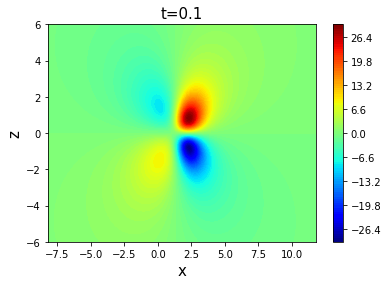

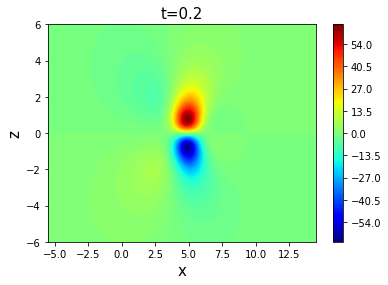

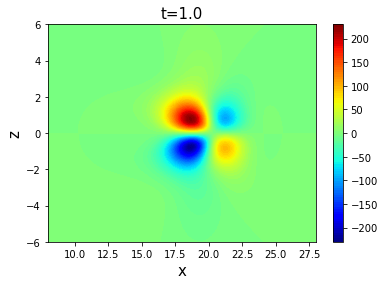

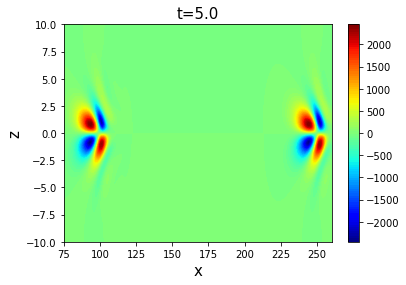

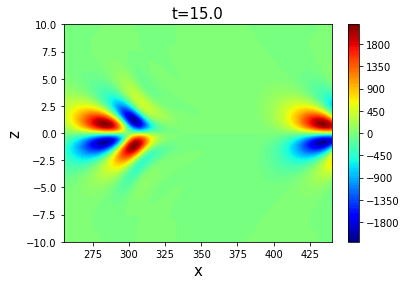

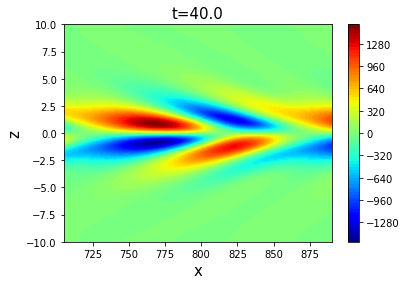

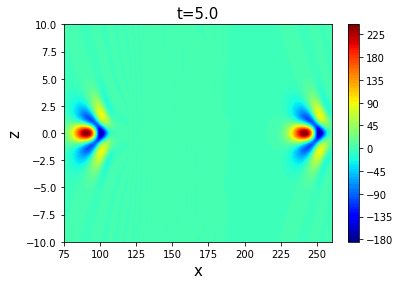

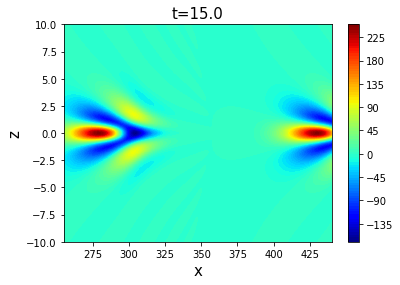

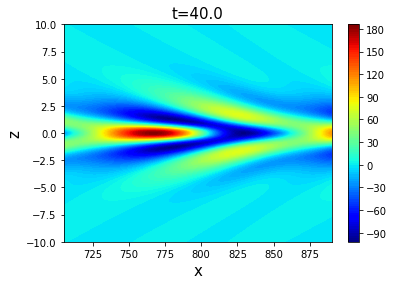

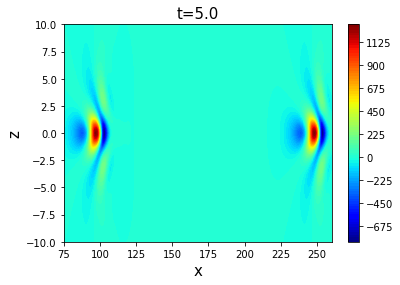

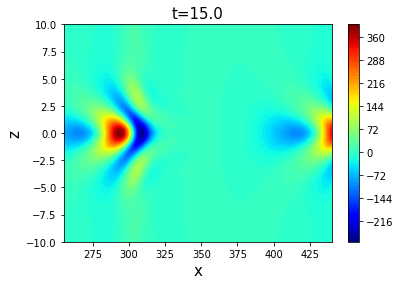

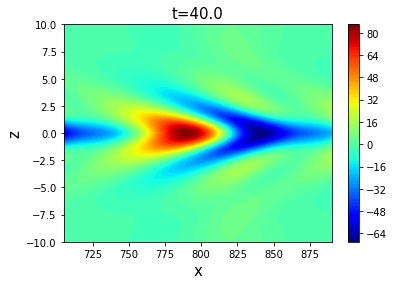

In [29]:
#def plotFunTemp(X,Z,fArr, t, fName, cl1,cl2,tk1,tk2,tkInt,xLim=None,yLim=None):
figureFolder = 'turbImpRes/'
def plotFunTemp(X,Z,fArr,t,fName):
    #plt.contourf(X,Z,fArr,100, cmap="jet")
    plt.contourf(X+18.*t,Z,fArr,100, cmap="jet")
    #plt.clim([cl1,cl2])
    #plt.colorbar(ticks=np.arange(tk1,1.01*tk2,tkInt))
    plt.colorbar()
    plt.xlabel("x", fontsize=15); plt.ylabel("z", fontsize=15)
    plt.title("t=%.1f"%t,fontsize=15)
    #if xLim is not None: plt.xlim(xLim)
    #if yLim is not None: plt.ylim(yLim)
    plt.savefig(figureFolder+fName,format='eps')
    plt.show()
    return


tArr = tArr1.copy()
for ind in range(tArr.size):
    plotFunTemp( X1,Z1,uFieldFz1[ind], tArr[ind],'uField1_t%d'%ind)

tArr = tArr2.copy()
for ind in range(tArr.size):
    plotFunTemp( X2,Z2,uFieldFz2[ind], tArr[ind],'uField2_t%d'%ind)


for ind in range(tArr.size):
    plotFunTemp( X2, Z2, uFieldFy[ind], tArr[ind],'vField2_t%d'%ind)

    

for ind in range(tArr.size):
    plotFunTemp( X2, Z2, uFieldFx[ind], tArr[ind],'uField2_t%d'%ind)
    
